Neural Networks
===============

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This tour details fully connected multi-layers neural networks for binary classification.

We recommend that after doing this Numerical Tours, you apply it to your
own data, for instance using a dataset from [LibSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/).

_Disclaimer:_ these machine learning tours are intended to be
overly-simplistic implementations and applications of baseline machine learning methods. For more advanced uses and implementations, we recommend
to use a state-of-the-art library, the most well known being
[Scikit-Learn](http://scikit-learn.org/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#  convert to a column vector
def MakeCol(y): return y.reshape(-1,1)
#  convert to a row vector
def MakeRow(y): return y.reshape(1,-1)
# find non zero/true elements
def find(x): return np.nonzero(x)[0]
# inner product 
def dotp(x,y): return sum( x.flatten() * y.flatten() )

Dataset Generation
------------------

We define a function to randomly generate samples, in dimension $p=2$.

In [3]:
p = 2
def rescale(u,a,b,a1,b1): return a1 + (u-a)*(b1-a1)/(b-a)
def gen_point(m):
  y = np.sign(np.random.randn(1,m))
  x = np.zeros((2,m))
  r = 1 + .1*np.random.rand(m) # radius
  t = np.pi/2 + np.pi*np.random.rand(m) # angle
  x[0,:] = r * np.sin(t)
  x[1,:] = r * np.cos(t)
  I = (y.flatten()<0) 
  x[0,I] = x[0,I] + 1
  x[1,I] = -.7-x[1,I] 
  # rescale within a box 
  x[0,:] = rescale(x[0,:], -1,2,  .2,.8)
  x[1,:] = rescale(x[1,:], -1,.6, .2,.8) 
  return x, y

Display a batch of data points.

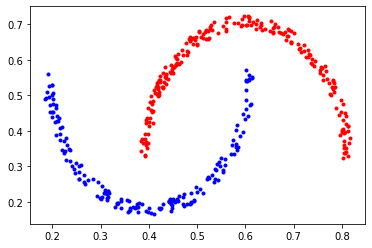

In [4]:
n = 400
x, y = gen_point(n)
plt.plot( x[0,y.flatten()>0], x[1,y.flatten()>0], 'b.' )
plt.plot( x[0,y.flatten()<0], x[1,y.flatten()<0], 'r.' );

Building the Network
--------------------
We setup the network. It is parameterized by the dimensions of the layers.


The network $\phi_\th$ is composed of $R$ layers, and operate by initialyzing $x_0=x$ and then iterating
$$ \forall r=0,\ldots,R, \quad x_{r+1} \eqdef \rho(A_r x_r + b_r).  $$
Here $\rho : \RR \mapsto \RR$ is a non-linear activation function which
operate coordinate by coordinate. The intermediate variables are $x_r \in \RR^{d_r}$
with $(d_0,d_{L+1})=(p,1)$. The matrices have size $A_r \in \RR^{d_{r+1} \times d_r}$ while the biases have size $b_r \in \RR^{d_{r+1}}$. The parameters of the networks are $\th \eqdef (A_r,b_r)_r$


The final value is obtained by comparing the predicted value $x_{R+1} = \phi_\th(x)$ to the data $y$ using some loss function
$$ \min_{\th} \EE( \ell(\phi_{\th}(x),y) ). $$


Load the loss and its gradient.
Here we use a logistic loss
$$ \ell(z,y) \eqdef \log( 1 + \exp(-y z) ) .  $$
$$ \ell'(z,y) \eqdef -y \frac{ \exp(-y z) }{ 1 + \exp(-y z) }.  $$

Note that in practice the computation is done in parallel over an array
$X$ of size $(p,n)$ of $n$ points in $\RR^p$, and $y \in \RR^{1 \times n}$.

In [5]:
def Loss(z,y): return 1/y.shape[1] * np.sum( np.log( 1 + np.exp(-y*z) ) )
def nablaLoss(z,y): return -1/y.shape[1] * y * np.exp(-y*z) / ( 1 + np.exp(-y*z) )

Load the activation function. Here we use an atan sigmoid function.

In [6]:
def rho(u): return np.arctan(u)
def rhoG(u): return 1/(1+u**2)

Display the activation.

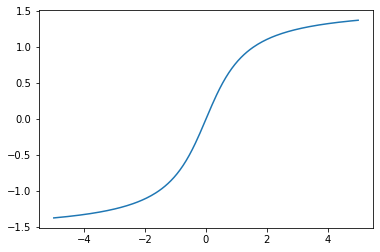

In [7]:
t = np.linspace(-5,5,201)
plt.clf
plt.plot(t, rho(t))
plt.axis('tight');

Dimensions $d_r$ of the layers. We use here a single hidden layer.

In [8]:
D = np.array([p,15,1])

Initialize the layers randomly.

In [9]:
R = D.size-1 
A = []
b = [] 
for r in np.arange(0,R):
    A.append(np.random.randn(D[r+1],D[r]))
    b.append(np.random.randn(D[r+1],1))

Evaluate the network.
Bookkeep the intermediate results: this is crucial for the computation of
the gradient.

In [10]:
def ForwardNN(A,b,x,R):
    X = []
    X.append(x)
    for r in np.arange(0,R):
        X.append( rho( A[r]@X[r] + np.tile(b[r],[1,x.shape[1]]) ) )
    return X

In [11]:
X = ForwardNN(A,b,x,R)
L = Loss(X[-1],y)

Network Optimization
--------------------

The network parameters are optimized by minimizing the non-convex
empirical loss minimization through gradient descent.

We first here consider batch gradient descent, where we use a batch of $n$ samples $x=(x^{i})_{i=1}^n, y=(y^i)_{i=1}^n$ and minimize
$$
  \min_{\th} f(\th) \eqdef \frac{1}{n} \sum_{i=1}^n \ell(\phi_{\th}(x^{i}),y^{i}) ). 
$$
using a simple fixed step-size gradient descent
$$
  \th \leftarrow \th - \tau \nabla  f(\th). 
$$

Initialize the gradient of $f$ with respect to $x_{R+1}$ as
$$ \nabla_{x_{R+1}} f = \ell'( x_{R+1},y) = ( \ell'( x_{R+1}^i,y^i) )_{i=1}^n \in \RR^{1 \times n}$$ 
where $\ell'$ is applied component wise to the columns $x_{R+1}^i$ of $x_{R+1}$ and $y$.

In [12]:
gx = nablaLoss(X[R],y)

The successive gradients with respect to the intermediate variables $x_r$
are solutions of a backward recursion, which
corresponds to the celebrated backpropagation algorithm.
$$ \forall r=R,\ldots,1, \quad
      \nabla_{x_{r}} f = A_r^\top M_r $$
where we denoted
$$ M_r \eqdef \rho'(A_r x_r + b_r ) \odot \nabla_{x_{r+1}} \ell, $$
where $\odot$ is entry-wise multiplications.


From these gradients with respect to the intermediate layers variables, the
gradient with respect to the network  paramters are retrieved as
$$ \nabla_{A_r} f = M_r x_r^\top, \qandq
    \nabla_{b_r} f = M_r 1_n.  $$


We now implement this back-propagation of $\nabla_{x_{R+1}} f$.

In [13]:
def BackwardNN(A,b,X,R,gx):
    gA = [] # gradient with respect to A
    gb = [] # gradient with respect to b
    n = X[0].shape[1] # number of samples in mini-batch
    for r in np.arange(0,R):
        gA.append([]) 
        gb.append([])
    for r in np.arange(R-1,-1,-1):
        M = rhoG( (A[r] @ X[r]) + np.tile(b[r],[1,n]) ) * gx
        # nabla_X[r] 
        gx = (A[r].T) @ M
        # nabla_A[r]
        gA[r] =  M @ (X[r].T)
        # nabla_b[r]
        gb[r] =  MakeCol(M.sum(axis=1))
    return [gA,gb]

We now implement the computation of $\nabla_\th f = (\nabla_A f,\nabla_b f)$ by performing first the forward pass and then the backward pass.

In [14]:
def ForwardBackwardNN(A,b,x,y):
    ## forward pass
    X = ForwardNN(A,b,x,R)
    L = Loss(X[R],y)
    gx = nablaLoss(X[R],y) # initialize the gradient
    [gA,gb] = BackwardNN(A,b,X,R,gx)
    return [L,gA,gb]

Initialize the layers randomly.

In [15]:
for r in np.arange(0,R):
    A[r] = np.random.randn(D[r+1],D[r])
    b[r] = np.random.randn(D[r+1],1)

Select the step size $\tau$. It should be roughly independent of the batch size $n$ (since the energy is normalized by $1/n$) but depends on the size and number of layers. You should try different values or implement Armijo backtracking linesearch.

In [16]:
tau = .5 # should work for R=2
if R==5:
    tau = .01/50
if R==3:
    tau = .01/80

We implement a batch gradient descent.

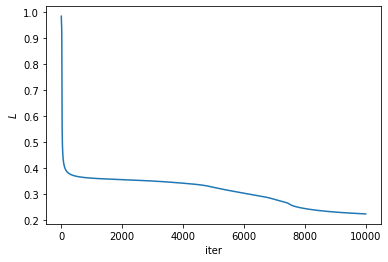

In [17]:
niter = 10000
L = np.zeros((niter,1))
for it in np.arange(0,niter):
    [L[it],gA,gb] = ForwardBackwardNN(A,b,x,y)
    for r in np.arange(0,R):
        A[r] = A[r] - tau*gA[r]
        b[r] = b[r] - tau*gb[r]
plt.clf
plt.plot(L)
plt.xlabel('iter')
plt.ylabel('$L$')
plt.axis('tight');

Generate a set of point $z_i \in \RR^p$ on a grid for evaluation.

In [18]:
q = 100;
t = np.linspace(0,1,q)
[U,V] = np.meshgrid(t,t)
z = np.vstack([V.flatten(), U.flatten()])

Classification "probability" at each loction $z$, computer as 
$$\frac{e^{f_\th(z)}}{1+e^{f_\th(z)}}.$$ 

In [19]:
def phi(r): return np.exp(r)/(1+np.exp(r))
V = ForwardNN(A,b,z,R)
U = np.reshape( phi(V[R].T), [q,q] )

Display the probability.

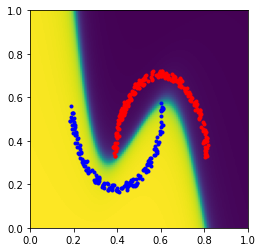

In [20]:
plt.clf
plt.imshow(U.T, origin="lower", extent=[0,1,0,1])
plt.plot( x[0,y.flatten()>0], x[1,y.flatten()>0], 'b.' )
plt.plot( x[0,y.flatten()<0], x[1,y.flatten()<0], 'r.' );

You can test the method using a different number of layers and check its influence.



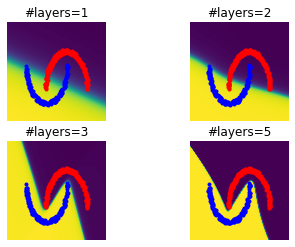

In [21]:
Layers = []
Layers.append([p, 1]) # vanilla logitic regression (convex)
Layers.append([p, 8, 1]) # single hidden layer
Layers.append([p, 3, 4, 1]) # 4 hidden layers
Layers.append([p, 4, 5, 8, 4, 1]) # 4 hidden layers
tau_list = np.array([.5, .5, .5, .5])
plt.clf
for il in np.arange(0,np.size(Layers)):
	D = Layers[il]
	# layers
	R = np.size(D)-1
	A = []
	b = []
	for r in np.arange(0,R):
	    A.append(np.random.randn(D[r+1],D[r]))
	    b.append(np.random.randn(D[r+1],1))
	# descent
	tau = tau_list[il]
	niter = 10000 
	L = np.zeros((niter,1))
	for it in np.arange(0,niter):
	    [L[it],gA,gb] = ForwardBackwardNN(A,b,x,y)
	    for r in np.arange(0,R):
	        A[r] = A[r] - tau*gA[r]
	        b[r] = b[r] - tau*gb[r]
	# display
	V = ForwardNN(A,b,z,R)
	U = np.reshape( phi(V[R].T), [q,q] )
	plt.subplot(2,2,il+1)
	plt.imshow(U.T, origin="lower", extent=[0,1,0,1])
	plt.plot( x[0,y.flatten()>0], x[1,y.flatten()>0], 'b.' )
	plt.plot( x[0,y.flatten()<0], x[1,y.flatten()<0], 'r.' )
	plt.axis('off');
	plt.title('#layers=' + str(len(D)-1))

# Automatic Differentiation using *AutoGrad*

Instead of computing the gradient "by hand", we use an automatic differentation toolbox, here [AutoGrad](https://github.com/HIPS/autograd).

It uses reverse mode automatic differentation to compute the gradient at the same expense at computing the function itself. 
See [this tutorial for more information](https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation).

In [22]:
import autograd.numpy as np
import autograd as ag
from autograd import elementwise_grad as egrad

Test on a scalar value function, computing and plotting higher-order derivatives.

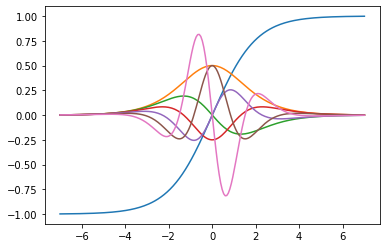

In [23]:
def tanh(x):
    return (1.0 - np.exp(-x))  / (1.0 + np.exp(-x))
t = np.linspace(-7, 7, 200)
plt.plot(t, tanh(t),
         t, egrad(tanh)(t),                                     # first derivative
         t, egrad(egrad(tanh))(t),                              # second derivative
         t, egrad(egrad(egrad(tanh)))(t),                       # third derivative
         t, egrad(egrad(egrad(egrad(tanh))))(t),                # fourth derivative
         t, egrad(egrad(egrad(egrad(egrad(tanh)))))(t),         # fifth derivative
         t, egrad(egrad(egrad(egrad(egrad(egrad(tanh))))))(t));  # sixth derivative

Gradient of a quadratic functions $f(u)=\dotp{M u}{u}/2$ for $M$ symmetric, $\nabla f(x)=Mx$.

In [24]:
M = np.random.randn(3,3)
M = M+M.T
def f(u): 
    return np.sum( .5 * u.T @ (M@u) )
u = np.random.randn(3,1)
g = ag.grad(f)
print('Should be 0: ' + str( np.linalg.norm(np.abs((g(u) - M@u) ) )))

Should be 0: 0.0


Function $f(\th)$ to be minimized for neural networks, where $\theta=(A,b)$.

In [25]:
def FuncNN(theta): 
    X = ForwardNN(theta[0],theta[1],x,R)
    return Loss(X[-1],y)

In [26]:
D = [p, 4, 5, 8, 4, 1]
R = np.size(D)-1
A = []
b = []
for r in np.arange(0,R):
    A.append(np.random.randn(D[r+1],D[r]))
    b.append(np.random.randn(D[r+1],1))

Compute the funcfion and the gradient

In [27]:
FuncNNG = ag.value_and_grad(FuncNN)
#X = ForwardNN(A,b,x,R)
#FuncNN((A,b))
[u,g] = FuncNNG((A,b))
gA = g[0] # gradient with respect to A 
gb = g[1] # gradient with respect to b

Compare with the gradient computed "by hand".

In [28]:
import numpy
[L,gA1,gb1] = ForwardBackwardNN(A,b,x,y)
R = np.size(A)
e = 0
for i in range(R):
    e += np.linalg.norm(gA[r]-gA1[r])
    e += np.linalg.norm(gb[r]-gb1[r])
print('Should be 0:' + str(e))

Should be 0:1.0408340855860843e-16


# Automatic Differentiation using *PyTorch*

Pytorch is a powerful deep learning library whose main feature is to perform automatic differentiation. One caveat is that one need to manipulate PyTorch tensors in place of Numpy arrays. An avantage with respect to AutoGrad is that it contains higher level primitive which allows to hide from the user the parameter of the layer (e.g. linear weights and bias).

In [29]:
import torch
import torch.nn as nn

We first define the architecture. You can try `nn.ReLu()` in place of nn.Sigmoid to obtain straight boundaries. One can try one the two following cell depending of the number of hidden layer you want.

In [30]:
D = [p, 4, 5, 8, 4, 1]
model = nn.Sequential(
      nn.Linear(D[0], D[1]),
      nn.Tanh(),
      nn.Linear(D[1], D[2]),
      nn.Tanh(),
      nn.Linear(D[2], D[3]),
      nn.Tanh(),
      nn.Linear(D[3], D[4]),
      nn.Tanh(),
      nn.Linear(D[4], D[5]),
)

In [31]:
D = [p, 40, 1]
model = nn.Sequential(
      nn.Linear(D[0], D[1]),
      nn.Tanh(),
      nn.Linear(D[1], D[2]),
)

In [32]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=40, bias=True)
  (1): Tanh()
  (2): Linear(in_features=40, out_features=1, bias=True)
)


Initialize the weights.

In [33]:
nn.init.normal_(model[0].bias, 0, 1)
nn.init.normal_(model[0].weight, 0,1)
nn.init.normal_(model[2].bias, 0, 1)
nn.init.normal_(model[2].weight, 0,1);

Convert arrays into PyTorch tensors. Beware that for PyTorch the data should be of size $(p,n)$, so we transpose the tensors. 

In [34]:
X = torch.Tensor(x).T
Y = torch.Tensor(y).T

Run the forward pass: evaluate the loss function.

In [35]:
loss = 1/n * torch.sum( -torch.log( torch.sigmoid(-model(X)*Y) ) )
print( loss.item() )

1.9115080833435059


Run the backward pass to evaluate the gradients of all the involved parameters.

In [36]:
model.zero_grad()
loss.backward()

Do the stepping:
$$ \theta \leftarrow \th - \tau \nabla f(\th). $$

In [37]:
tau = .5
with torch.no_grad():
  for theta in model.parameters():
    theta -= tau * theta.grad

Putting all together: implement the batch gradient descent.

In [38]:
tau = .4
niter = 10000
L = np.zeros((niter,1))
for i in range(niter):
    # loss = 1/n * torch.sum( torch.LogSigmoid(-model(X)*Y) )
    loss = 1/n * torch.sum( -torch.log( torch.sigmoid(model(X)*Y) ) )
    L[i] = loss.item()
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
      for theta in model.parameters():
        theta -= tau * theta.grad

Plot the evolution of the training loss.

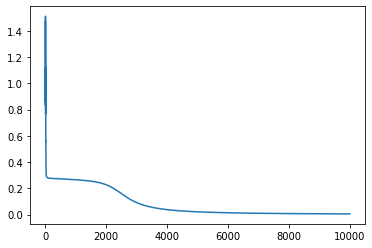

In [39]:
plt.plot(L);

Vizualize the application of the network on the grid point defined by `z`.

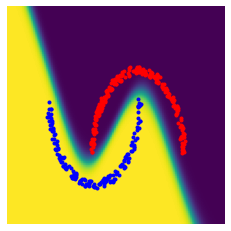

In [40]:
V = model(torch.Tensor(z).T)
V = V.detach().numpy() # convert back to numpy array
U = np.reshape( phi(V), [q,q] )
plt.imshow(U.T, origin="lower", extent=[0,1,0,1])
plt.plot( x[0,y.flatten()>0], x[1,y.flatten()>0], 'b.' )
plt.plot( x[0,y.flatten()<0], x[1,y.flatten()<0], 'r.' )
plt.axis('off');